# Variational Quantum Linear Solver (VQLS)

## Example 1: Solve Ax = b where A ={{1 0},{0 2}} and b = 0.707 {1 1}

In [23]:
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

I = SparsePauliOp.from_list([("I", 1.0)])
Z = SparsePauliOp.from_list([("Z", 1.0)])
X = SparsePauliOp.from_list([("X",1.0)])

#Step 1: Define operator A
A_op = 0.5 * (I + Z) + (I - Z)

#Step 2: Create |b><b| operator
b_op = 0.5 * (I + X)

#Step 3: create Hamiltonian H = A^+ (I - |b><b| ) A
Hamiltonian = A_op @ (I - b_op) @ A_op

#checking H is hermitian
print("Is Hermitian?", np.allclose(Hamiltonian.to_matrix(), Hamiltonian.to_matrix().conj().T))

#Checking any imaginary coefficients
print("Imag part of coeffs:", np.imag(Hamiltonian.coeffs).max())

#Display the Hamiltonian as matrix
print("Cost_Hamiltonian:",Hamiltonian.to_matrix())

# Make the operator Hermitian (just in case)
Hamiltonian = 0.5 * (Hamiltonian + Hamiltonian.adjoint())

# Strip all imaginary parts: only real part is needed
Hamiltonian = SparsePauliOp(Hamiltonian.paulis, coeffs=np.real(Hamiltonian.coeffs))

#Step 4: Create Ansatz
def ansatz(params):
    qc = QuantumCircuit(1)
    qc.ry(params[0],0)
    return qc

#Step5:Cost evaluation
def costfunction(params):
    state = ansatz(params)
    job = estimator.run([(state,Hamiltonian)])
    result = job.result()
    exact_value = float(result[0].data.evs)
    return exact_value

#Step 6: Optimization
initial_params = [0.1]
result = minimize(costfunction, initial_params, method='COBYLA')
print("Optimal Parameters:", result.x)
print("Minimum Cost:", result.fun)


Is Hermitian? True
Imag part of coeffs: 0.5
Cost_Hamiltonian: [[ 0.5+0.j -1. +0.j]
 [-1. +0.j  2. +0.j]]
Optimal Parameters: [0.92725]
Minimum Cost: 1.2779172164911756e-09


## Example 2: A = {{3/4 1/4},{1/4 3/4}} and b = {0 1}

In [30]:
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

I = SparsePauliOp.from_list([("I", 1.0)])

#Step 1: Operator A
A_mat = np.array([[3/4,1/4],[1/4,3/4]])
A_op = SparsePauliOp.from_operator(A_mat)

#Step2: Operator from b (|b><b|)
b_mat = np.array([[0,0],[0,1]])
b_op = SparsePauliOp.from_operator(b_mat)

#step3: Cost Hamiltonian
Ham = A_op @ (I - b_op) @ A_op

#checking H is hermitian
print("Is Hermitian?", np.allclose(Ham.to_matrix(), Ham.to_matrix().conj().T))

#Checking any imaginary coefficients
print("Imag part of coeffs:", np.imag(Ham.coeffs).max())

#Display the Hamiltonian as matrix
print("Cost_Hamiltonian:",Ham.to_matrix())

# Make the operator Hermitian (just in case)
Ham = 0.5 * (Ham + Ham.adjoint())

# Strip all imaginary parts: only real part is needed
Ham = SparsePauliOp(Ham.paulis, coeffs=np.real(Ham.coeffs))

#Step 4: Create ansatz
def ansatz(params):
    qc = QuantumCircuit(1)
    qc.ry(params[0],0)
    return qc

#Step 5: evaluate cost function
def costfunc(params):
    state = ansatz(params)
    job = estimator.run([(state,Ham)])
    result = job.result()
    value  = result[0].data.evs
    return value

#step 6: optimization
initial_params = [0.1]
result = minimize(costfunc, initial_params, method='COBYLA')
print("Optimal Parameters:", result.x)
print("Minimum Cost:", result.fun)


Is Hermitian? True
Imag part of coeffs: 0.09375
Cost_Hamiltonian: [[0.5625+0.j 0.1875+0.j]
 [0.1875+0.j 0.0625+0.j]]
Optimal Parameters: [-2.4981]
Minimum Cost: 1.117039793996355e-11


## Example 3: For a two-qubit system

For a 4x4 matrix, A = {{4 1 0 0},{1 3 1 0},{0 1 2 1},{0 0 1 1}}, b = {0 1 2 1} 

<IPython.core.display.Latex object>

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5])])
6


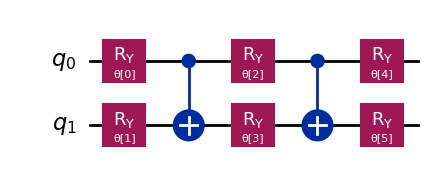

In [20]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector,DensityMatrix
import numpy as np

b_vec = np.array([0, 1, 2, 1])
b_vec = b_vec / np.linalg.norm(b_vec)

bqs = DensityMatrix(b_vec)
display(bqs.draw("latex"))

from qiskit.circuit.library import n_local

twolocal = n_local(2, rotation_blocks="ry", entanglement_blocks="cx", entanglement="linear", reps=2)
print(twolocal.parameters)
print(twolocal.num_parameters)

display(twolocal.draw("mpl"))

Is Hermitian? True
Imag part of coeffs: 0.5
Cost_Hamiltonian: [[ 1.68333333e+01+0.j  6.16666667e+00+0.j -6.93889390e-18+0.j
  -5.00000000e-01+0.j]
 [ 6.16666667e+00+0.j  6.83333333e+00+0.j -1.19348975e-15+0.j
  -1.50000000e+00+0.j]
 [-2.15105711e-16+0.j -1.24900090e-15+0.j -5.32907052e-15+0.j
  -1.02001740e-15+0.j]
 [-5.00000000e-01+0.j -1.50000000e+00+0.j -7.56339436e-16+0.j
   5.00000000e-01+0.j]]


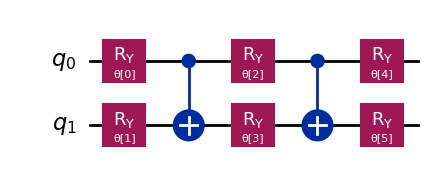

Optimal Parameters: [1.7262871  5.48122901 0.0140801  0.00667839 4.55631395 3.94372629]
Minimum Cost: 3.0560529902520306e-06


In [21]:
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp,DensityMatrix
from qiskit.circuit.library import TwoLocal,n_local
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

II = SparsePauliOp.from_list([("II", 1.0)])

#Step 1: Operator A
A_mat = np.array([[4,1,0,0],[1,3,1,0],[0,1,2,1],[0,0,1,1]])
A_op = SparsePauliOp.from_operator(A_mat)

#Step 2: |b> vector normalized, encoding in circuit and creating a density matrix |b><b|
b_vec = np.array([0, 1, 2, 1])
b_vec = b_vec / np.linalg.norm(b_vec)
b_mat = DensityMatrix(b_vec)
b_op = SparsePauliOp.from_operator(b_mat)

#step 3: Cost Hamiltonian
Ham = A_op @ (II - b_op) @ A_op

#checking H is hermitian
print("Is Hermitian?", np.allclose(Ham.to_matrix(), Ham.to_matrix().conj().T))

#Checking any imaginary coefficients
print("Imag part of coeffs:", np.imag(Ham.coeffs).max())

#Display the Hamiltonian as matrix
print("Cost_Hamiltonian:",Ham.to_matrix())

# Make the operator Hermitian (just in case)
Ham = 0.5 * (Ham + Ham.adjoint())

# Strip all imaginary parts: only real part is needed
Ham = SparsePauliOp(Ham.paulis, coeffs=np.real(Ham.coeffs))

#Step 4: Create ansatz (two-local circuit)

ansatz = n_local(2, rotation_blocks="ry", entanglement_blocks="cx", entanglement="linear", reps=2)
display(ansatz.draw("mpl"))
#As for pre-defined circuits, qiskit automatically creates symbolic parameters.
#So to create a circuit with parameters, one has to use "bind_parameters(params)" function; It replaces them with numerical values

#Step 5: evaluate cost function
def costfunc(params):
    #state = ansatz.bind_parameters(params)
    job = estimator.run([(ansatz,Ham,params)])
    result = job.result()
    value  = result[0].data.evs
    return value

#step 6: optimization
initial_params = np.random.uniform(0, 2*np.pi, size=ansatz.num_parameters)
result = minimize(costfunc, initial_params, method='COBYLA')
print("Optimal Parameters:", result.x)
print("Minimum Cost:", result.fun)


To get the solution from above parameters and compare with the classical solution.

In [22]:
# To create the statevector from above optimal values
from qiskit.quantum_info import Statevector

# Create circuit with optimal parameters
optimal_params = result.x
optimal_circuit = ansatz.assign_parameters(optimal_params)

# Get statevector from the circuit
statevector = Statevector.from_instruction(optimal_circuit)

# Show vector (solution |x⟩)
print("Approximate solution |x⟩:", statevector.data)
display(statevector.draw("latex"))


Approximate solution |x⟩: [ 4.11285382e-04+0.j -1.59312402e-03+0.j  9.99984311e-01+0.j
 -5.35453612e-03+0.j]


<IPython.core.display.Latex object>

In [23]:
#Classsical Solution
# Original A matrix
Acl = np.array([[4,1,0,0],
              [1,3,1,0],
              [0,1,2,1],
              [0,0,1,1]])

# Original b vector
bcl = np.array([0,1,2,1])
bcl = bcl / np.linalg.norm(bcl)

# Classical solution
x_classical = np.linalg.solve(Acl, bcl)
x_classical = x_classical / np.linalg.norm(x_classical)  # normalized for comparison
print("Classical normalized solution:", x_classical)


Classical normalized solution: [0. 0. 1. 0.]


In [24]:
#Comparison
# Quantum state from VQLS
x_quantum = statevector.data
x_quantum = x_quantum / np.linalg.norm(x_quantum)

# Inner product (fidelity)
fidelity = np.abs(np.dot(np.conj(x_classical), x_quantum)) ** 2

print(f"Fidelity between quantum and classical solutions: {fidelity:.6f}")


Fidelity between quantum and classical solutions: 0.999969


## Example 3: Linear differential equation 

y''(x) + x = 0, y(0) = y(1) = 0

For 

### Using 1 qubit (4 data points)

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector,DensityMatrix
import numpy as np

b_vec = np.array([1/3, 2/3])
b_vec = b_vec / np.linalg.norm(b_vec)

bqs = DensityMatrix(b_vec)
display(bqs.draw("latex"))

<IPython.core.display.Latex object>

In [5]:
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

I = SparsePauliOp.from_list([("I", 1.0)])

#Step 1: Operator A
A_mat = np.array([[18,-9],[-9,18]])
A_op = SparsePauliOp.from_operator(A_mat)

#Step2: Operator from b (|b><b|)
b_vec = np.array([1/3, 2/3])
b_vec = b_vec / np.linalg.norm(b_vec)
b_mat = DensityMatrix(b_vec)
b_op = SparsePauliOp.from_operator(b_mat)

#step3: Cost Hamiltonian
Ham = A_op @ (I - b_op) @ A_op

#checking H is hermitian
print("Is Hermitian?", np.allclose(Ham.to_matrix(), Ham.to_matrix().conj().T))

#Checking any imaginary coefficients
print("Imag part of coeffs:", np.imag(Ham.coeffs).max())

#Display the Hamiltonian as matrix
print("Cost_Hamiltonian:",Ham.to_matrix())

# Make the operator Hermitian (just in case)
Ham = 0.5 * (Ham + Ham.adjoint())

# Strip all imaginary parts: only real part is needed
Ham = SparsePauliOp(Ham.paulis, coeffs=np.real(Ham.coeffs))

#Step 4: Create ansatz
def ansatz(params):
    qc = QuantumCircuit(1)
    qc.ry(params[0],0)
    return qc

#Step 5: evaluate cost function
def costfunc(params):
    state = ansatz(params)
    job = estimator.run([(state,Ham)])
    result = job.result()
    value  = result[0].data.evs
    return value

#step 6: optimization
initial_params = [0.1]
result = minimize(costfunc, initial_params, method='COBYLA')
print("Optimal Parameters:", result.x)
print("Minimum Cost:", result.fun)



Is Hermitian? True
Imag part of coeffs: 48.599999999999994
Cost_Hamiltonian: [[ 405. +0.j -324. +0.j]
 [-324. +0.j  259.2+0.j]]
Optimal Parameters: [1.7921]
Minimum Cost: 1.925752712850226e-08


In [11]:
# To create the statevector from above optimal values
from qiskit.quantum_info import Statevector
import numpy as np

# Create circuit with optimal parameters
theta = result.x
data = np.array([np.cos(theta/2), np.sin(theta/2)])

# Get statevector from the circuit
statevector = Statevector(data)

# Show vector (solution |x⟩)
print("Approximate solution |x⟩:", statevector.data)
display(statevector.draw("latex"))

#Classical Solution
x_classical = np.linalg.solve(A_mat, b_vec)
x_classical = x_classical / np.linalg.norm(x_classical)  # normalized for comparison
print("Classical normalized solution:", x_classical)

#Comparison
# Quantum state from VQLS
x_quantum = statevector.data
x_quantum = x_quantum / np.linalg.norm(x_quantum)

# Inner product (fidelity)
fidelity = np.abs(np.dot(np.conj(x_classical), x_quantum)) ** 2

print(f"Fidelity between quantum and classical solutions: {fidelity:.6f}")


Approximate solution |x⟩: [0.62469925+0.j 0.78086545+0.j]


<IPython.core.display.Latex object>

Classical normalized solution: [0.62469505 0.78086881]
Fidelity between quantum and classical solutions: 1.000000


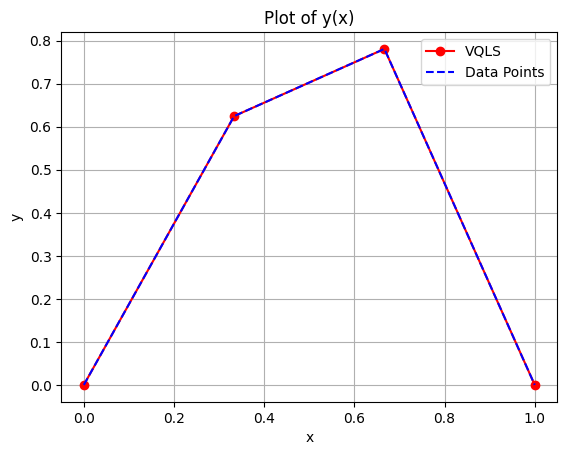

In [32]:
#Classical solution for Differential equation y''(x) + x = 0
import matplotlib.pyplot as plt
import numpy as np

x_val = np.linspace(0,1,4)
y_qm = [0] + [x_quantum[0]] + [x_quantum[1]] + [0]
y_cl = [0] + [x_classical[0]] + [x_classical[1]] + [0]


plt.plot(x_val,y_qm,'ro-',label = "VQLS")
plt.plot(x_val,y_cl,'b--',label = 'Data Points')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of y(x)")
plt.legend()
plt.grid(True)

plt.show()

Tried for 3 qubits, solution matches exactly with classical solution.

### Using more qubits ( 4 qubits (16 data points))

In [14]:
#Creating the finite difference matrix 
import numpy as np

n=16
mat = np.zeros([n,n])

mat[0][0]=1
mat[n-1][n-1]=1

for i in range(1,n-1):
    mat[i][i-1]=1
    mat[i][i]=-2
    mat[i][i+1]=1
mat

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0

Solving same equation using 4 qubits

Is Hermitian? False
Imag part of coeffs: 8.641975308641975e-06


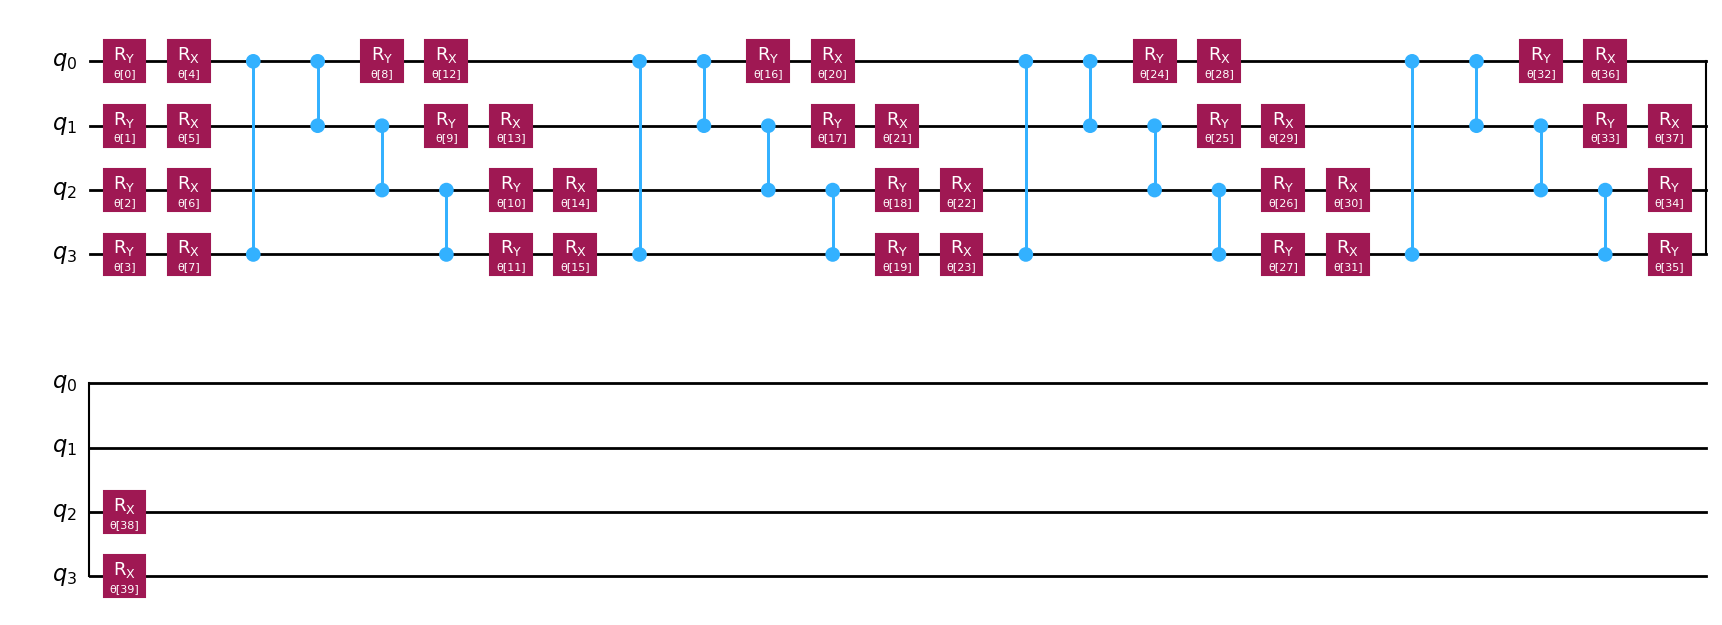

Optimal Parameters: [3.65295626 1.80579076 1.74050392 5.08806833 6.32340103 2.37048792
 0.27706494 2.4705371  4.356196   5.83681534 0.29859219 2.400567
 0.67224258 1.47467758 4.22043465 0.04881445 5.898506   1.10485758
 2.82066668 1.49171137 1.58410695 1.56711699 6.07167376 3.45900857
 0.70980638 0.91103461 6.05412603 3.28861305 5.40041392 2.69100456
 4.81173628 4.30047119 0.19024124 2.59142526 4.16955528 2.04300265
 1.80271789 5.7822896  3.14845819 6.84961746]
Minimum Cost: 6.501819368427662e-07


In [19]:
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp,DensityMatrix
from qiskit.circuit.library import n_local
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

I4 = SparsePauliOp.from_list([("IIII", 1.0)])

#Step 1: Operator A
h = 1/(n-1) 
A_mat = -h * h * mat
A_op = SparsePauliOp.from_operator(A_mat)

#Step2: Operator from b (|b><b|)
b = np.zeros(n)
for i in range(1,n-1):
    b[i]=i/(n-1) 

b_vec = b
b_vec = b_vec / np.linalg.norm(b_vec)
b_mat = DensityMatrix(b_vec)
b_op = SparsePauliOp.from_operator(b_mat)

#step3: Cost Hamiltonian
Ham = A_op @ (I4 - b_op) @ A_op

#checking H is hermitian
print("Is Hermitian?", np.allclose(Ham.to_matrix(), Ham.to_matrix().conj().T))

#Checking any imaginary coefficients
print("Imag part of coeffs:", np.imag(Ham.coeffs).max())

#Display the Hamiltonian as matrix
#print("Cost_Hamiltonian:",Ham.to_matrix())

# Make the operator Hermitian (just in case)
Ham = 0.5 * (Ham + Ham.adjoint())

# Strip all imaginary parts: only real part is needed
Ham = SparsePauliOp(Ham.paulis, coeffs=np.real(Ham.coeffs))

#Step 4: Create ansatz (two-local circuit)

ansatz = n_local(4, rotation_blocks=["ry","rx"], entanglement_blocks="cz", entanglement="circular", reps=4)
display(ansatz.draw("mpl"))
#As for pre-defined circuits, qiskit automatically creates symbolic parameters.
#So to create a circuit with parameters, one has to use "bind_parameters(params)" function; It replaces them with numerical values

#Step 5: evaluate cost function
def costfunc(params):
    #state = ansatz.bind_parameters(params)
    job = estimator.run([(ansatz,Ham,params)])
    result = job.result()
    value  = result[0].data.evs
    return value

#step 6: optimization
initial_params = np.random.uniform(0, 2*np.pi, size=ansatz.num_parameters)
result = minimize(costfunc, initial_params, method='COBYLA')
print("Optimal Parameters:", result.x)
print("Minimum Cost:", result.fun)

Creating state vector from optimal parameters and comparing with classical solution:

In [20]:
# To create the statevector from above optimal values
from qiskit.quantum_info import Statevector

# Create circuit with optimal parameters
optimal_params = result.x
optimal_circuit = ansatz.assign_parameters(optimal_params)

# Get statevector from the circuit
statevector = Statevector.from_instruction(optimal_circuit)
x_quantum = statevector.data
print("Quantum solution |x⟩:", x_quantum)
#display(statevector.draw("latex"))

#Classical Solution
x_classical = np.linalg.solve(A_mat, b_vec)
x_classical = x_classical / np.linalg.norm(x_classical)  # normalized for comparison
print("Classical normalized solution:", x_classical)

Quantum solution |x⟩: [-6.65408940e-02-0.06687524j  4.14678660e-02+0.09821368j
  8.50549437e-02+0.19718401j  9.27372033e-02+0.26980715j
  7.06886887e-02+0.27456985j  3.41186318e-02+0.20759881j
 -2.79895239e-04+0.09970967j -5.69743574e-03-0.0041868j
  3.79935469e-02-0.08262944j  1.35704262e-01-0.11949242j
  2.60850942e-01-0.14465601j  3.72525029e-01-0.16131363j
  4.28826834e-01-0.15612541j  3.70620976e-01-0.12456518j
  2.06669741e-01-0.06846742j -1.18977879e-01+0.01236683j]
Classical normalized solution: [-0.          0.0620846   0.12250622  0.17960188  0.2317086   0.2771634
  0.31430329  0.3414653   0.35698645  0.35920376  0.34645424  0.31707492
  0.26940282  0.20177495  0.11252834 -0.        ]


0.3471627390055585


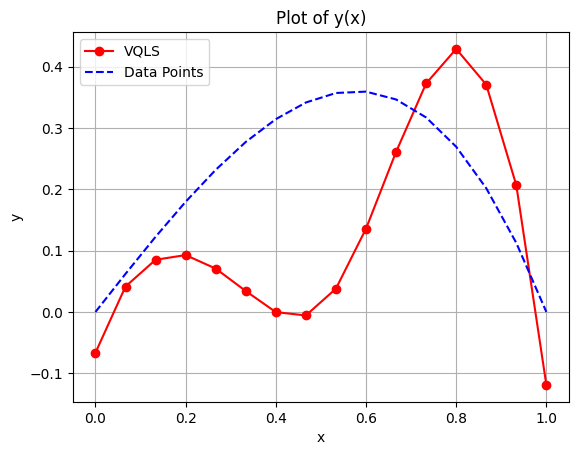

In [21]:
#Classical solution for Differential equation y''(x) + x = 0
import matplotlib.pyplot as plt
import numpy as np

x_val = np.linspace(0,1,n)
y_qm = np.zeros(n)
for i in range(n):
    y_qm[i] = x_quantum[i].real

y_cl = np.zeros(n)
for i in range(n):
    y_cl[i] = x_classical[i]

max_error = max(abs(y_cl-y_qm))
print(max_error)

plt.plot(x_val,y_qm,'ro-',label = "VQLS")
plt.plot(x_val,y_cl,'b--',label = 'Data Points')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of y(x)")
plt.legend()
plt.grid(True)

plt.show()

Need more time to minimize the error. Have to tweak the ansatz to gte better results.

## Example 4: Non-linear differential equations

### Method I: Iterative VQLS using Newton's Method

Consider a Non-linear ODE with polynomial non-linear terms

y''(x) + 2 y^3 = 0, y(0) = 1, y'(0) = 0

In [5]:
import numpy as np

# Parameters
L = 1.0           # Domain length
n = 8             # Total grid points including boundaries
h = L / (n - 1)   # Step size

# Discretized points
x = np.linspace(0, L, n)
print(x)

# Initial guess for y (interior points only)
y = np.ones(n)  # including boundary values
print(y)

# Function F(y): Nonlinear system from FD discretization
def compute_F(y):
    F = np.zeros(n)
    F[0] = y[0] - 1
    F[1] = y[1] - 1
    for i in range(2, n-1):
        y_im1 = y[i - 1] 
        y_i = y[i]
        y_ip1 = y[i + 1]
        F[i] = (y_ip1 - 2 * y_i + y_im1) / h**2 + 2 * y_i**3
    F[n-1] = (y[n-1] - 2 * y[n-2] + y[n-3]) / h**2 + 2 * y[n-1]**3
    return F

# Jacobian matrix J
def compute_J(y):
    J = np.zeros((n,n))
    J[0,0] = 1
    J[1,1] = 1
    for i in range(2, n-1): 
        J[i, i + 1] = 1 / h**2
        J[i, i] = -2 / h**2 + 6 * y[i]**2
        if i > 2:
            J[i, i - 1] = 1 / h**2
    J[n-1,n-1] = 1/ h**2 + 6 * y[n-1]
    J[n-1,n-2] = -2/h**2
    J[n-1,n-3] = 1/ h**2
    return J

# Initial vector
y_full = np.ones(n)

# Compute F and J for one Newton step
F_val = compute_F(y_full)
J_val = compute_J(y_full)

F_val, J_val


[0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ]
[1. 1. 1. 1. 1. 1. 1. 1.]


(array([0., 0., 2., 2., 2., 2., 2., 2.]),
 array([[  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., -92.,  49.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  49., -92.,  49.,   0.,   0.,   0.],
        [  0.,   0.,   0.,  49., -92.,  49.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  49., -92.,  49.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  49., -92.,  49.],
        [  0.,   0.,   0.,   0.,   0.,  49., -98.,  55.]]))

For 3 qubits

Is Hermitian? False
Imag part of coeffs: 925.6406250000005
Cost_Hamiltonian: [[ 1.00000000e+00+0.j  1.59161573e-12+0.j  1.59161573e-12+0.j
  -1.13686838e-13+0.j -2.27373675e-13+0.j -6.25277607e-13+0.j
   1.80300219e-12+0.j -1.27897692e-13+0.j]
 [-1.59161573e-12+0.j  1.00000000e+00+0.j  5.68434189e-13+0.j
  -1.36424205e-12+0.j  3.41060513e-13+0.j  9.94759830e-14+0.j
  -1.71240799e-12+0.j  0.00000000e+00+0.j]
 [ 2.27373675e-13+0.j  3.41060513e-13+0.j  1.05568333e+04+0.j
  -8.97300000e+03+0.j  2.44400000e+03+0.j  3.94166667e+02+0.j
  -1.01050000e+03+0.j  7.45333333e+02+0.j]
 [-7.95807864e-13+0.j -4.54747351e-13+0.j -8.97300000e+03+0.j
   1.32600000e+04+0.j -9.02200000e+03+0.j  2.34600000e+03+0.j
   1.41000000e+02+0.j -1.04000000e+02+0.j]
 [-1.56319402e-13+0.j -1.13686838e-13+0.j  2.44400000e+03+0.j
  -9.02200000e+03+0.j  1.32600000e+04+0.j -9.07100000e+03+0.j
   2.54200000e+03+0.j -1.04000000e+02+0.j]
 [ 4.26325641e-13+0.j -2.13162821e-13+0.j  4.30000000e+01+0.j
   2.39500000e+03+0.j -9.0

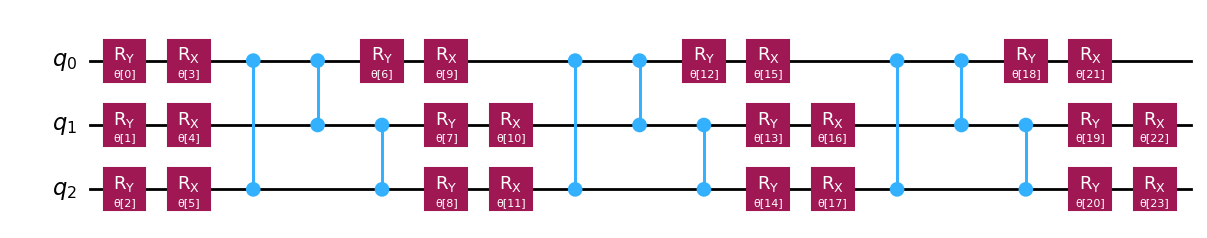

Optimal Parameters: [2.08976543 2.38216968 4.41317118 3.58763305 0.24595311 3.95935839
 0.947466   4.72853341 0.89009041 3.21123867 6.27329577 3.21308459
 2.89286313 5.48762875 3.50885356 0.23070374 2.71248391 4.4843881
 4.78937102 0.74963235 4.7812613  4.71008767 4.80211377 1.11774421]
Minimum Cost: -2471.909911236832


In [6]:
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp,DensityMatrix
from qiskit.circuit.library import n_local
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

I3 = SparsePauliOp.from_list([("III", 1.0)])

#Step 1: Operator A = J
A_mat = J_val
A_op = SparsePauliOp.from_operator(A_mat)

#Step2: Operator from b (|b><b|)
b_vec  = F_val
b_vec = b_vec / np.linalg.norm(b_vec)
b_mat = DensityMatrix(b_vec)
b_op = SparsePauliOp.from_operator(b_mat)

#step3: Cost Hamiltonian
Ham = A_op @ (I3 - b_op) @ A_op

#checking H is hermitian
print("Is Hermitian?", np.allclose(Ham.to_matrix(), Ham.to_matrix().conj().T))

#Checking any imaginary coefficients
print("Imag part of coeffs:", np.imag(Ham.coeffs).max())

#Display the Hamiltonian as matrix
print("Cost_Hamiltonian:",Ham.to_matrix())

# Make the operator Hermitian (just in case)
Ham = 0.5 * (Ham + Ham.adjoint())

# Strip all imaginary parts: only real part is needed
Ham = SparsePauliOp(Ham.paulis, coeffs=np.real(Ham.coeffs))

#Step 4: Create ansatz (two-local circuit)

ansatz = n_local(3, rotation_blocks=["ry","rx"], entanglement_blocks="cz", entanglement="circular", reps=3)
display(ansatz.draw("mpl"))
#As for pre-defined circuits, qiskit automatically creates symbolic parameters.
#So to create a circuit with parameters, one has to use "bind_parameters(params)" function; It replaces them with numerical values

#Step 5: evaluate cost function
def costfunc(params):
    #state = ansatz.bind_parameters(params)
    job = estimator.run([(ansatz,Ham,params)])
    result = job.result()
    value  = result[0].data.evs
    return value

#step 6: optimization
initial_params = np.random.uniform(0, 2*np.pi, size=ansatz.num_parameters)
result = minimize(costfunc, initial_params, method='COBYLA')
print("Optimal Parameters:", result.x)
print("Minimum Cost:", result.fun)

In [7]:
# To create the statevector from above optimal values
from qiskit.quantum_info import Statevector

# Create circuit with optimal parameters
optimal_params = result.x
optimal_circuit = ansatz.assign_parameters(optimal_params)

# Get statevector from the circuit
statevector = Statevector.from_instruction(optimal_circuit)
x_quantum = statevector.data
print("Quantum solution |x⟩:", x_quantum)
#display(statevector.draw("latex"))

#Classical Solution
x_classical = np.linalg.solve(A_mat, b_vec)
x_classical = x_classical / np.linalg.norm(x_classical)  # normalized for comparison
print("Classical normalized solution:", x_classical)

Quantum solution |x⟩: [-0.0007223 +0.01255042j  0.01786673+0.01260166j -0.02194437-0.08525127j
 -0.02164401-0.09709364j -0.01418153-0.08512747j  0.0072041 -0.00290215j
 -0.05552882-0.19974572j  0.27924806+0.92371509j]
Classical normalized solution: [0.         0.         0.13319826 0.26696691 0.38492611 0.47263187
 0.51934473 0.51934473]


0.57487354509634


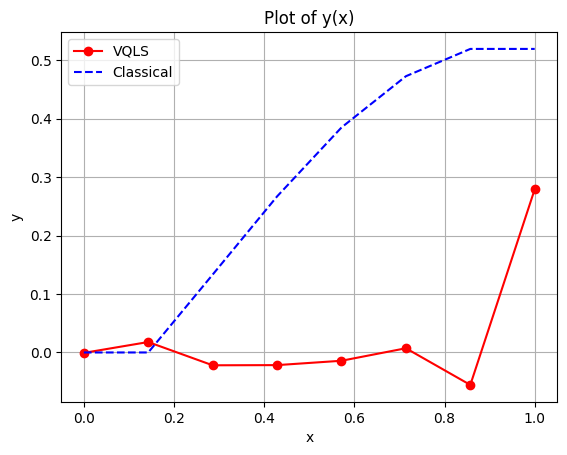

In [17]:
#Classical solution for Differential equation y''(x) + 2 x^3 = 0
import matplotlib.pyplot as plt
import numpy as np

x_val = np.linspace(0,1,n)
y_qm = np.zeros(n)
for i in range(n):
    y_qm[i] = x_quantum[i].real

y_cl = np.zeros(n)
for i in range(n):
    y_cl[i] = x_classical[i]

max_error = max(abs(y_cl-y_qm))
print(max_error)

plt.plot(x_val,y_qm,'ro-',label = "VQLS")
plt.plot(x_val,y_cl,'b--',label = 'Classical')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of y(x)")
plt.legend()
plt.grid(True)

plt.show()

In [16]:
#To update new y values
deltaycl=np.linalg.solve(A_mat, b_vec)
norm = np.linalg.norm(deltaycl)
print(norm)
deltay = norm * x_quantum
print(deltay)

y_new = np.zeros(n)
for i in range(n):
    y_new[i] = deltay[i].real + y_full[i]

print(y_full)
print(y_new)

0.49356702617921866
[-0.0003565 +0.00619448j  0.00881843+0.00621976j -0.01083102-0.04207722j
 -0.01068277-0.04792222j -0.00699954-0.04201611j  0.0035557 -0.00143241j
 -0.02740719-0.0985879j   0.13782764+0.45591531j]
[1. 1. 1. 1. 1. 1. 1. 1.]
[0.9996435  1.00881843 0.98916898 0.98931723 0.99300046 1.0035557
 0.97259281 1.13782764]


Use the y_new vector to implement again VQLS to find next y values. 

Repeat the process until |\delta y| << \epsilon, where \epsilon ~ O(10^-6) or smaller

### Method II: Using paper (Entropy 2024, 26, 1009)

#### Implementing Classically

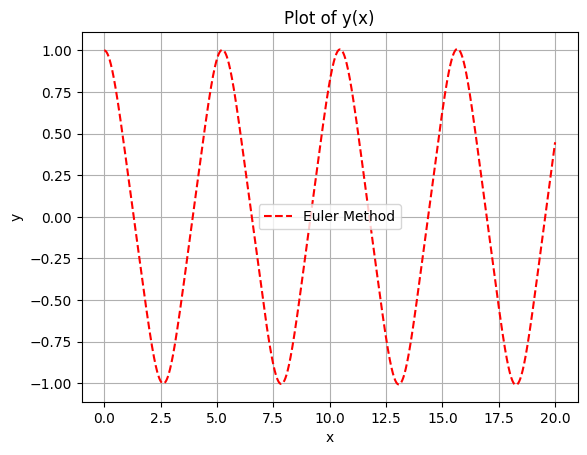

In [27]:
#Try with usual Euler Method
import numpy as np
import matplotlib.pyplot as plt

nff = 20000
h = 0.001

yvec = np.zeros(nff)
vvec = np.zeros(nff)

yvec[0] = 1
vvec[0] = 0

for i in range(1,nf):
    yvec[i] = yvec[i-1] + h * vvec[i-1]
    vvec[i] = vvec[i-1] - 2 * h * yvec[i-1]**3

Ra = h * nff
x_val = np.linspace(0,Ra,nff)

plt.plot(x_val,yvec,'r--',label = 'Euler Method')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of y(x)")
plt.legend()
plt.grid(True)

plt.show()

[[ 1.     0.     0.     0.     0.   ]
 [ 0.     1.     0.     0.     0.   ]
 [-1.    -0.001  1.     0.     0.   ]
 [ 0.    -1.     0.     1.     0.002]
 [ 0.     0.     0.     0.     1.   ]]
Classical normalized solution: [1.         1.         0.999998   ... 0.44579389 0.44679639 0.44779872]


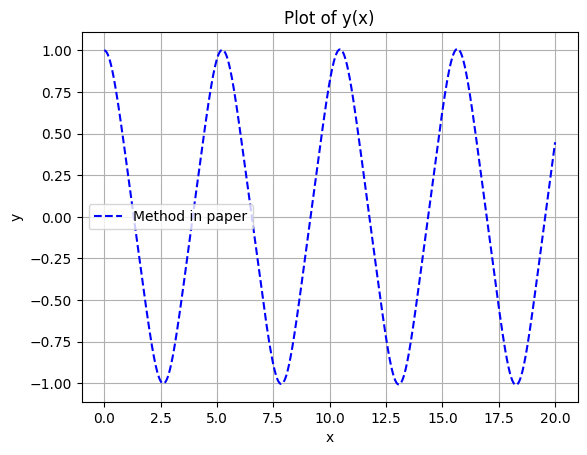

In [29]:
#Solving Classically using method described in Paper
import numpy as np
import matplotlib.pyplot as plt

n1 = 8
h = 0.001 #Step Size

Amat = np.zeros((n1-3,n1-3))
for i in range(n1-3):
    Amat[i,i] = 1
Amat[2,0] = -1
Amat[2,1] = - h
Amat[3,1] = -1
Amat[3,4] = 2*h

print(Amat)

#initial vector and final vector
bvec = [1,0,0,0,1]
nf = 20000
y_fin = np.zeros(nf)
y_fin[0] = bvec[0]

for i in range(1,nf):
    sol_cl = np.linalg.solve(Amat, bvec)
    bvec[0] = sol_cl[2]
    bvec[1] = sol_cl[3]
    bvec[4] = sol_cl[2]**3
    y_fin[i] = sol_cl[2]

print("Classical normalized solution:", y_fin)

Ra = h * nf
x_val = np.linspace(0,Ra,nf)

plt.plot(x_val,y_fin,'b--',label = 'Method in paper')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of y(x)")
plt.legend()
plt.grid(True)

plt.show()

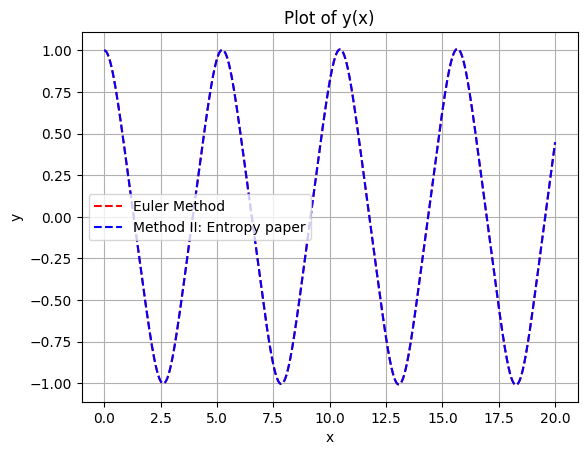

In [28]:
#Combining Both methods

plt.plot(x_val,yvec,'r--',label = 'Euler Method')
plt.plot(x_val,y_fin,'b--',label = 'Method II: Entropy paper')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of y(x)")
plt.legend()
plt.grid(True)

plt.show()

#### Implementing using Quantum Computing

##### A simple non-linear ODE (y' + 2 y^2 = 0, y(0) = 1)

In [26]:
import numpy as np
import matplotlib.pyplot as plt

#Create matrix A
n1 = 4
h = 0.001 #Step Size

A1 = np.zeros((n1,n1))
for i in range(n1-1):
    A1[i,i] = 1
A1[1,0] = -1
A1[1,2] = 2 * h

print(A1)

A1_dag = A1.conj().T

print(A1_dag)

n= 2*n1
Amat = np.zeros((n,n))
for i in range(n1):
    for j in range(n1,n):
        Amat[i,j] = A1[i,j-n1]

for i in range(n1,n):
    for j in range(n1):
        Amat[i,j] = A1_dag[i-n1,j]

print(Amat)

print("Condition number of Amat:", np.linalg.cond(Amat))
print("Is Hermitian?", np.allclose(A1, A1.conj().T))

Ma = 0.5 * (A1 + A1.conj().T)
print("Is Hermitian?", np.allclose(Ma, Ma.conj().T))
print("Condition number of A1:", np.linalg.cond(Ma))

print("Rank:", np.linalg.matrix_rank(Ma))
print("Singular values:", np.linalg.svd(Ma, compute_uv=False))


[[ 1.     0.     0.     0.   ]
 [-1.     1.     0.002  0.   ]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     0.   ]]
[[ 1.    -1.     0.     0.   ]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.002  1.     0.   ]
 [ 0.     0.     0.     0.   ]]
[[ 0.     0.     0.     0.     1.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -1.     1.     0.002  0.   ]
 [ 0.     0.     0.     0.     0.     0.     1.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 1.    -1.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.002  1.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]]
Condition number of Amat: inf
Is Hermitian? False
Is Hermitian? True
Condition number of A1: inf
Rank: 3
Singular values: [1.500001 1.       0.499999 0.      ]


In [28]:
import numpy as np

n = 4
Amat = np.eye(n) * 2 + np.diag(np.ones(n-1), 1) + np.diag(np.ones(n-1), -1)
bvec = np.ones(n)

print(Amat)
print(bvec)
# Solve classically
x_classical = np.linalg.solve(Amat, bvec)

# Check condition number
print("Condition number:", np.linalg.cond(Amat))


[[2. 1. 0. 0.]
 [1. 2. 1. 0.]
 [0. 1. 2. 1.]
 [0. 0. 1. 2.]]
[1. 1. 1. 1.]
Condition number: 9.472135954999578


##### A Second order non-linear ODE

In [13]:
import numpy as np
import matplotlib.pyplot as plt

#Create matrix A
n1 = 8
h = 0.001 #Step Size

A1 = np.zeros((n1,n1))
for i in range(n1-3):
    A1[i,i] = 1
A1[2,0] = -1
A1[2,1] = - h
A1[3,1] = -1
A1[3,4] = 2*h

print(A1)

A1_dag = A1.conj().T

print(A1_dag)

n= 2*n1
Amat = np.zeros((n,n))
for i in range(n1):
    for j in range(n1,n):
        Amat[i,j] = A1[i,j-n1]

for i in range(n1,n):
    for j in range(n1):
        Amat[i,j] = A1_dag[i-n1,j]

print(Amat)

print("Condition number of Amat:", np.linalg.cond(Amat))


[[ 1.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.     0.   ]
 [-1.    -0.001  1.     0.     0.     0.     0.     0.   ]
 [ 0.    -1.     0.     1.     0.002  0.     0.     0.   ]
 [ 0.     0.     0.     0.     1.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]]
[[ 1.     0.    -1.     0.     0.     0.     0.     0.   ]
 [ 0.     1.    -0.001 -1.     0.     0.     0.     0.   ]
 [ 0.     0.     1.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     1.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.002  1.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]]
[[ 0.     0.     0.     0.     0.     0.     0.     0.

In [11]:
#Creating Loop with VQLS code in it
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp,DensityMatrix,Statevector
from qiskit.circuit.library import n_local
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

I4 = SparsePauliOp.from_list([("IIII", 1.0)])

# Defining Operator A and vector B
A_op = SparsePauliOp.from_operator(Amat)
bvec = [1,0,0,0,1,0,0,0]
Bvec1 = np.zeros(n)
for i in range(n1):
    Bvec1[i] = bvec[i]

#Define the cost function
def costfunc(params):
    job = estimator.run([(ansatz,Ham,params)])
    result = job.result()
    value  = result[0].data.evs
    return value

#Creating a VQLS loop
nf = 5 #iterations
y_fin = np.zeros(nf) #Initialising the final solution
y_fin[0] = bvec[0] 

for i in range(1,nf):  
    #Operator from b (|b><b|)
    B_vec = Bvec1 / np.linalg.norm(Bvec1)
    B_mat = DensityMatrix(B_vec)
    B_op = SparsePauliOp.from_operator(B_mat)
    
    #Cost Hamiltonian
    Ham = A_op @ (I4 - B_op) @ A_op

    #Checking H is hermitian
    print("Is Hermitian?", np.allclose(Ham.to_matrix(), Ham.to_matrix().conj().T))

    #Checking any imaginary coefficients
    print("Imag part of coeffs:", np.imag(Ham.coeffs).max())

    # Make the operator Hermitian (just in case)
    Ham = 0.5 * (Ham + Ham.adjoint())

    # Strip all imaginary parts: only real part is needed
    Ham = SparsePauliOp(Ham.paulis, coeffs=np.real(Ham.coeffs))

    #Step 4: Create ansatz (two-local circuit)
    ansatz = n_local(4, rotation_blocks=["ry","rx"], entanglement_blocks="cz", entanglement="circular", reps=2)
    
    #step 6: optimization
    initial_params = np.random.uniform(0, 2*np.pi, size=ansatz.num_parameters)
    result = minimize(costfunc, initial_params, method='COBYLA')
    optimal_params = result.x
    optimal_circuit = ansatz.assign_parameters(optimal_params)
    statevector = Statevector.from_instruction(optimal_circuit)
    y_quantum = statevector.data

    #Classical solution of matrix (needed for norm)
    #y_cl = np.linalg.solve(Amat, Bvec1)
    y_cl = np.linalg.pinv(Amat) @ Bvec1
    norm = np.linalg.norm(y_cl)
    y_quantum = norm * y_quantum

    #Array of solution
    y_qm = np.zeros(n)
    for k in range(n):
        y_qm[k] = y_quantum[k].real
        
    #update B vector
    Bvec1[0] = y_qm[2]
    Bvec1[1] = y_qm[3]
    Bvec1[4] = y_qm[2]**3

    #Final solution
    y_fin[i] = y_qm[2]
    print(y_fin[i])

print("Quantum normalized solution:", y_fin)



Is Hermitian? True
Imag part of coeffs: 0.15625
2.086475634248492e-06
Is Hermitian? True
Imag part of coeffs: 0.15625
-1.9624197828105238e-10
Is Hermitian? True
Imag part of coeffs: 0.15625
3.30513717149762e-13
Is Hermitian? True
Imag part of coeffs: 0.15625
-5.257853888649058e-16
Quantum normalized solution: [ 1.00000000e+00  2.08647563e-06 -1.96241978e-10  3.30513717e-13
 -5.25785389e-16]


C:\Users\gnara\AppData\Local\Temp\ipykernel_86792\734586724.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


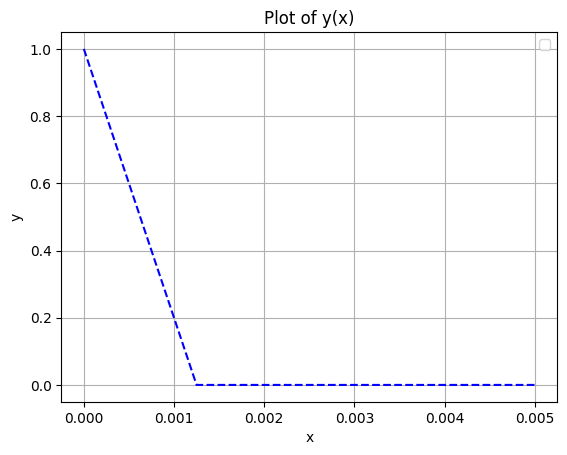

In [12]:
import matplotlib.pyplot as plt
import numpy as np

Ra = h * nf
x_val = np.linspace(0,Ra,nf)

plt.plot(x_val,y_fin,'b--')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of y(x)")
plt.legend()
plt.grid(True)

plt.show()

## Example 5: Non-linear differential equations (simple pendulum problem)